In [ ]:
! pip install 'h5py==2.10.0' --force-reinstall

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
#Run this twice to install correct version of keras

!pip install -U keras==2.1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.1.5-py2.py3-none-any.whl (334 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [4]:
import tensorflow
import skimage
import keras
print(tensorflow.__version__,  skimage.__version__, keras.__version__)
import os
import cv2
import numpy as np
import imageio
from scipy import ndimage
from glob import glob
import zipfile
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras.layers.core import Lambda

Using TensorFlow backend.


1.15.2 0.18.3 2.1.5


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
IMG_ROWS = 256
IMG_COLS = 256
n_classes=4 #Number of classes for segmentation

In [7]:
batch_size = 8

os.chdir("/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses/")
!pwd
path = "/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses/"
img_dir = "./train/"
mask_dir = "./masks/"


/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses


In [8]:
#Capture training image info as a list
train_images = []

for directory_path in glob( path + "/train/"):
    for img_path in sorted(glob(os.path.join(directory_path, "*.jpg"))):
        # print(img_path)
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (IMG_ROWS, IMG_COLS))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob(path + "/masks/"):
    for mask_path in sorted(glob(os.path.join(directory_path, "*.jpg"))):        
        # print(mask_path)
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (IMG_ROWS, IMG_COLS), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


In [9]:
print(np.unique(train_masks))
for i in range(0,len(train_masks)):
  train_masks[i] = np.where(train_masks[i] > 3, 0, train_masks[i])
print(np.unique(train_masks))

[0 1 2 3 4 5 6]
[0 1 2 3]


In [10]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [11]:
from keras.utils import normalize
#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, 
                                          random_state = 0)
#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, 
                                                                random_state = 0)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


Class values in the dataset are ...  [0 1 2 3]


In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

In [13]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, 
                            IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]     

In [14]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat), 
                    # class_weight=class_weights,
                    shuffle=False)
                    
model.save(path + '/implant_test.hdf5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1440 samples, validate on 200 samples
Epoch 1/200





1440/1440 [==============================] - 30s 21ms/step - loss: 0.3464 - acc: 0.9238 - val_loss: 0.2536 - val_acc: 0.9331
Epoch 2/200
1440/1440 [==============================] - 17s 12ms/step - loss: 0.2052 - acc: 0.9322 - val_loss: 0.2150 - val_acc: 0.9331
Epoch 3/200
1440/1440 [==============================] - 17s 12ms/step - loss: 0.1705 - acc: 0.9322 - val_loss: 0.1823 - val_acc: 0.9331
Epoch 4/200
1440/1440 [==============================] - 17s 12ms/step - loss: 0.1417 - acc: 0.9420 - val_loss: 0.1376 - val_acc: 0.9431
Epoch 5/200
1440/1440 [==============================] - 17s 12ms/step - loss: 0.1271 - acc: 0.9471 - val_loss: 0.1195 - val_acc: 0.9454
Epoch 6/200
1440/1440 [==============================] - 17s 12ms/step - loss: 0.1166 - acc: 0.9503 - val_loss: 0.1060 - val_acc: 0.9515
Epoch 7/200
1440/1440 [======

200/200 [==============================] - 2s 11ms/step
Accuracy is =  99.02374267578125 %


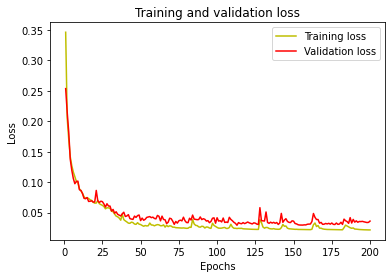

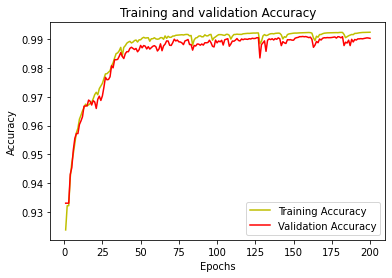

In [15]:
from matplotlib import pyplot as plt

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
#If starting with pre-trained weights. 
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=256, 
                            IMG_WIDTH=256, IMG_CHANNELS=1)
model.load_weights(path + '/implant_test.hdf5')

In [17]:


#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for bg is: ", class1_IoU)
print("IoU for bego is: ", class2_IoU)
print("IoU for bicon is: ", class3_IoU)
print("IoU for straumann is: ", class4_IoU)

labels = ['bego', 'bicon', 'straumann']
probs = [class2_IoU, class3_IoU, class4_IoU]
result = dict(zip(labels, probs))
print(result)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

ImportError: ignored

In [18]:
# Need ground truth and predict existing
def calculateProbabilityForTestingImage(y_ground, y_prediction):
    from keras.metrics import MeanIoU
    n_classes = 4
    IOU_keras = MeanIoU(num_classes=n_classes)  
    IOU_keras.update_state(y_ground, y_prediction)
    print("Mean IoU =", IOU_keras.result().numpy())
    
    #To calculate I0U for each class...
    values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
    print(values)
    if (values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0]) > 0:
        class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
    else:
        class1_IoU = 0
        
    if (values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1]) > 0:
        class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
    else:
        class2_IoU = 0
    
    if (values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2]) > 0:
        class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
    else:
        class3_IoU = 0
        
    if (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3]) >0:
        class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
    else:
        class4_IoU = 0
    
    print("IoU for bg is: ", class1_IoU)
    print("IoU for bego is: ", class2_IoU)
    print("IoU for bicon is: ", class3_IoU)
    print("IoU for straumann is: ", class4_IoU)
    
    labels = ['bego', 'bicon', 'straumann']
    probs = [class2_IoU, class3_IoU, class4_IoU]
    result = dict(zip(labels, probs))
    return result
    


def calculateProbabilityOnPredictedImage(predicted_img):
    unique, counts = np.unique(predicted_img, return_counts=True)
    dic = dict(zip(unique, counts))
    total = sum(dic.values())  - dic.get(0)
    # 1 = bego, 2 = bicon, 3 = straumann
    if total > 0:
        if dic.get(1) is not None:
            prob_bego = dic.get(1)/total
        else:
            prob_bego = 0
            
        if dic.get(2) is not None:
            prob_bicon = dic.get(2)/total
        else:
            prob_bicon = 0
        
        if dic.get(3) is not None:
            prob_straumann = dic.get(3)/total
        else:
            prob_straumann = 0
    else:
        prob_bego = 0
        prob_bicon = 0
        prob_straumann = 0
        
    prob_dic = dict(zip(['bego', 'bicon', 'straumann'], [prob_bego, prob_bicon, prob_straumann]))
    return prob_dic


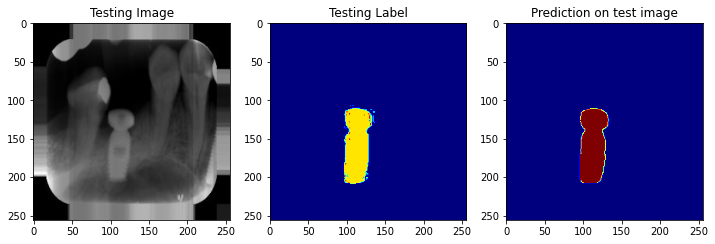

groud_truth {0: 62521, 1: 237, 2: 2743, 3: 35}
pred_label {0: 62505, 1: 151, 2: 2880}


{'bego': 0.04981854173540086, 'bicon': 0.9501814582645991, 'straumann': 0}

In [21]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

# print(np.unique(predicted_img))
# print(np.unique(prediction))

unique, counts = np.unique(ground_truth, return_counts=True)
print('groud_truth', dict(zip(unique, counts)))
unique, counts = np.unique(predicted_img, return_counts=True)
print('pred_label', dict(zip(unique, counts)))
#####################################################################
# test_result = calculateProbabilityForTestingImage(ground_truth, predicted_img)
calculateProbabilityOnPredictedImage(predicted_img)

In [22]:
test_new_img_path = path + "/new_test/"
text_result = []
for directory_path in glob(test_new_img_path):
    print(directory_path)
    for test_new_img_path in glob(directory_path + "/**/*.jpg",recursive=True):
        print(test_new_img_path)
        new_img = cv2.imread(test_new_img_path, 0)       
        new_img = cv2.resize(new_img, (IMG_ROWS, IMG_COLS))
        
        test_img_norm = normalize(new_img)
        test_img_input = np.expand_dims(test_img_norm, 0)
        test_img_input = np.expand_dims(test_img_input, 3)
        prediction = (model.predict(test_img_input))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        cal_rel = calculateProbabilityOnPredictedImage(predicted_img)
        #print(cal_rel)
        ap_text = test_new_img_path + ',' + str(cal_rel)
        text_result.append(ap_text)

import pandas as pd

df = pd.DataFrame(text_result)
df.to_csv('./text_multiclass_result.csv')

/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (811).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (777).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (822).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (793).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (806).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (819).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (766).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (760).jpg
/content/drive/MyDrive/1_ImplantProject/dataset_unet_multiclasses//new_test/bicon/bicon (791).jpg
/content/drive/MyDrive/1_ImplantProject/d